## Setup

### Imports

In [1]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
import numpy as np
import pandas as pd
from itertools import product
import IPython.display as ipd
import matplotlib.pyplot as plt
import tqdm

from src.ftm import constants as FTM_constants
from src.knn import KnnG
from src.phi import MSS_ref_factory



### Create Parameters Dataset

In [2]:
# Create DataFrame and write it to a CSV file for later use

def create_DF(bounds, subdiv, path):
    
    #Linspace of every parameters of size k
    Dbase = np.zeros((subdiv,5))
    for i in range(5):
        Dbase[:,i] = np.linspace(bounds[1][i][0],bounds[1][i][1],subdiv)
    baseDF = pd.DataFrame(data=Dbase,columns=bounds[0])

    #Product of the linspaces to get all the possible combinations (size subdiv**5, will take time)
    D = list(product(baseDF['omega'],baseDF['tau'],baseDF['p'],baseDF['d'],baseDF['alpha']))
    DF = pd.DataFrame(data=D,columns=bounds[0])

    DF.to_csv(path)
    
    return DF


In [3]:
# Boundaries

bounds = [['omega', 'tau', 'p', 'd', 'alpha'],
 [(2.4, 3.8),
  (0.4, 3),
  (-5, -0.7),
  (-5, -0.5),
  (10e-05, 1)]]

# Only run this to recreate the parameters CSV, this can take a long time to finish depending on the subdivision

create_DF(bounds=bounds, subdiv=2, path='data/default_parameters.csv')


,omega,tau,p,d,alpha
0,2.4,0.4,-5.0,-5.0,0.0001
1,2.4,0.4,-5.0,-5.0,1.0000
2,2.4,0.4,-5.0,-0.5,0.0001
3,2.4,0.4,-5.0,-0.5,1.0000
4,2.4,0.4,-0.7,-5.0,0.0001
5,2.4,0.4,-0.7,-5.0,1.0000
6,2.4,0.4,-0.7,-0.5,0.0001
7,2.4,0.4,-0.7,-0.5,1.0000
8,2.4,3.0,-5.0,-5.0,0.0001
9,2.4,3.0,-5.0,-5.0,1.0000


## Main

In [4]:
# Setting the parameters
DatasetPath = "data/default_parameters.csv"
DF = torch.from_numpy(pd.read_csv(DatasetPath, index_col=0).to_numpy()).to(device).to(float)
parameters_name = ["omega","tau","p","d","alpha"]
logscale = True
k = 10
total_iter = int(DF.size(dim=0)**2)

# Main job
print('computing the knn (P-loss)')
with tqdm.tqdm(total=total_iter) as pbar:
    T_knn_ploss = KnnG(DF,k,MSS_ref_factory,logscale,FTM_constants,'P-loss',update_pb=pbar.update)

print('computing the knn (Perceptual-KNN)')
with tqdm.tqdm(total=total_iter) as pbar:
    T_knn_perceptualknn = KnnG(DF,k,MSS_ref_factory,logscale,FTM_constants,'Perceptual-KNN',update_pb=pbar.update)

print('computing the knn (Bruteforce)')
with tqdm.tqdm(total=total_iter) as pbar:
    T_knn_bruteforce = KnnG(DF,k,MSS_ref_factory,logscale,FTM_constants,'Bruteforce',update_pb=pbar.update)

computing the knn (P-loss)


100%|██████████| 1024/1024 [00:00<00:00, 1743.70it/s]


computing the knn (Perceptual-KNN)


100%|██████████| 1024/1024 [00:03<00:00, 278.41it/s]


computing the knn (Bruteforce)


100%|██████████| 1024/1024 [00:11<00:00, 86.40it/s]


# Method characterization

In [29]:
from src.distances import distance_factory
from src.phi import MSS_ref_factory
from src.ftm import rectangular_drum

# We'll be judging the KNN algorithm by looking at the KNN using only the 1st point as reference
theta_r = T_knn_bruteforce[0,0,:]
x_r = rectangular_drum(theta_r, logscale, **FTM_constants)
phi = MSS_ref_factory(x_r)
S_r = phi(x_r)

P-loss         [0.0, 318358.96875, 1112052.25, 2189505.75, 1083074.0, 1125335.0, 2405080.0, 3255465.75, 108150.2734375, 416602.9375]
Perceptual-KNN [0.0, 318358.96875, 252033.921875, 731733.4375, 108150.2734375, 416602.9375, 252016.75, 116795.875, 1083074.0, 1125335.0]
Bruteforce     [0.0, 108150.2734375, 116795.875, 252016.75, 252033.921875, 318358.96875, 416602.9375, 695798.625, 731733.4375, 787496.0]


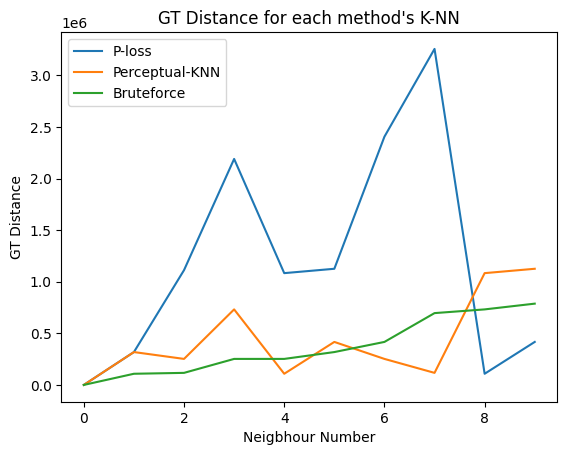

In [31]:
dist = distance_factory(phi,logscale,FTM_constants,"Bruteforce")

Dploss = []
Dperceptualknn = []
Dbruteforce = []

for i in range(k):
    Dploss.append(dist(T_knn_ploss[0,i,:],S_r).item())
    Dperceptualknn.append(dist(T_knn_perceptualknn[0,i,:],S_r).item())
    Dbruteforce.append(dist(T_knn_bruteforce[0,i,:],S_r).item())

print("P-loss         "+str(Dploss))
print("Perceptual-KNN "+str(Dperceptualknn))
print("Bruteforce     "+str(Dbruteforce))

plt.figure(1)

x = np.linspace(0,len(Dploss)-1,len(Dploss))
plt.plot(x,Dploss,x,Dperceptualknn,x,Dbruteforce)
plt.xlabel("Neigbhour Number")
plt.ylabel("GT Distance")
plt.legend(['P-loss', 'Perceptual-KNN', 'Bruteforce'])
plt.title("GT Distance for each method's K-NN")
plt.show()